# Investigating Effects of Hurricanes on the Power Grid

<description of problem, mention paper, investigation of question>

Sam animations of Harvey, other storms

# Clustering storms by landfall locations

<plug in ian's code>
<map, bar chart>

# Clusters against power data

<plug in my stuff here>
<outages by cluster for storms of <x> intensity>

# Conclusions:
* The data supports the hypothesis that hurricane location is a more significant predictor of blackouts than intensity

In [180]:
from power_outage_data import load_yearly_data, load_fips_shapes, lat_lon_to_fips
from storm_data import (
    load_clusters,
    load_tracks,
    date_str_to_storm_time,
    storm_time_to_datetime,
    get_intensity
)

yearly_power_data = load_yearly_data()
fips_shapes = load_fips_shapes()
clusters = load_clusters()
# Load tracks and prefilter for year.
tks = load_tracks()
tks = tks.where(tks.season>=2014, drop=True)

In [222]:
# iterate over each cluster

def lookup_storms_in_cluster(cluster):
    storm_dicts = []
    for _, row in cluster.iterrows():
        d = row.to_dict()
        start = date_str_to_storm_time(d['first_landfall_time']) - 0.01
        end = date_str_to_storm_time(d['final_landfall_time']) + 0.01
        sid = bytes(d['sid'], 'utf-8')

        storms = tks.where(
            (tks['time'] >= start) & (tks['time'] <= end) & (tks['sid'] == sid),
            drop=True
        )
        storm = storms.sel(storm=0)
        lon = storm.lon.values
        lat = storm.lat.values
        if (lon.size == 0) or (lat.size == 0):
            print(f"Couldn't find data for storm {d['name']} with sid {sid}")
            continue
        fips_codes = []
        county = []
        state = []
        for lat, lon in zip(lat, lon):
            fips = lat_lon_to_fips(lat, lon, fips_shapes)
            if fips:
                fips_codes.append(fips['id'])
                county.append(fips['properties']['NAME'])
                state.append(fips['properties']['STATE'])
            else:
                fips_codes.append(None)
                county.append(None)
                state.append(None)

        storm_dict = {
            **d,
            'year': int(storm.season.values[0]),
            'intensity': get_intensity(storm),
            'times': [storm_time_to_datetime(time) for time in storm.time.values],
            'lon': storm.lon.values,
            'lat': storm.lat.values,
            'fips_code': fips_codes,
            'county': county
        }
        storm_dicts.append(storm_dict)

    return storm_dicts


cluster_0 = list(clusters)[0][1]
cluster_0_storms = lookup_storms_in_cluster(cluster_0)
cluster_0_storms[1]


{'storm': 21,
 'sid': '2019299N25265',
 'name': 'OLGA',
 'fullmoment_label': 0,
 'spatmoment_label': 0,
 'first_landfall_time': '2019-10-26 06:00:00',
 'final_landfall_time': '2019-10-27 15:00:00',
 'year': 2019,
 'intensity': np.float32(45.0),
 'times': [datetime.datetime(2019, 10, 26, 6, 0),
  datetime.datetime(2019, 10, 26, 9, 0),
  datetime.datetime(2019, 10, 26, 12, 0),
  datetime.datetime(2019, 10, 26, 15, 0),
  datetime.datetime(2019, 10, 26, 18, 0),
  datetime.datetime(2019, 10, 26, 21, 0),
  datetime.datetime(2019, 10, 27, 0, 0),
  datetime.datetime(2019, 10, 27, 3, 0),
  datetime.datetime(2019, 10, 27, 6, 0),
  datetime.datetime(2019, 10, 27, 9, 0),
  datetime.datetime(2019, 10, 27, 12, 0),
  datetime.datetime(2019, 10, 27, 15, 0)],
 'lon': array([-91.200005, -90.554405, -90.      , -89.65197 , -89.3     ,
        -88.67649 , -88.      , -87.565056, -87.      , -86.10014 ,
        -84.7     , -82.69062 ], dtype=float32),
 'lat': array([28.8     , 30.048195, 31.7     , 33.8744

In [223]:
storms_by_cluster_id = {}
for cluster_id, cluster in clusters:
    cluster_storms = lookup_storms_in_cluster(cluster)
    storms_by_cluster_id[cluster_id] = cluster_storms



# Combine Storm & Power Data

In [231]:
import pandas as pd

from power_outage_data import load_customers_by_fips

customers_by_fips = load_customers_by_fips()

def get_blackouts_by_fip_for_storm(storm):
    power_outage_data = yearly_power_data[storm['year']]

    storm_df = pd.DataFrame({
        'fips_code': storm['fips_code'],
        'date': [time.date() for time in storm['times']],
        'hour': [time.hour for time in storm['times']],
        'lat': storm['lat'],
        'lon': storm['lon'],
    })
    merged  = storm_df.merge(power_outage_data.drop(columns='hour'), on=['fips_code', 'date'], how='left')
    if 'customers_out' not in merged.columns:
        print(f"Could not join power data for storm {storm['name']}")
        return pd.DataFrame()

    affected_fips = [code for code in merged['fips_code'].unique() if code]
    affected_fips_data = power_outage_data[power_outage_data['fips_code'].isin(affected_fips)]
    data = []
    for fips_code in affected_fips:
        fips_customers = customers_by_fips.get(fips_code)
        if fips_customers is None:
            print(f"Could not find customer data for fips code {fips_code}")
            continue
        # Retrieve customers_out data from the week before the storm
        before_storm = affected_fips_data[
            (affected_fips_data['fips_code'] == fips_code) &
            (affected_fips_data['date'] >= storm['times'][0].date() - pd.Timedelta(days=14)) &
            (affected_fips_data['date'] < storm['times'][0].date() - pd.Timedelta(days=7))
        ]
        during_storm = affected_fips_data[
            (affected_fips_data['fips_code'] == fips_code) &
            (affected_fips_data['date'] >= storm['times'][0].date()) &
            (affected_fips_data['date'] < storm['times'][-1].date() + pd.Timedelta(days=7))
        ]
        after_storm = affected_fips_data[
            (affected_fips_data['fips_code'] == fips_code) &
            (affected_fips_data['date'] >= storm['times'][-1].date() + pd.Timedelta(days=7)) &
            (affected_fips_data['date'] < storm['times'][-1].date() + pd.Timedelta(days=14))
        ]

        before = before_storm['customers_out'].max()
        during = during_storm['customers_out'].max()
        after = after_storm['customers_out'].max()
        # check for nans
        if pd.isna(before) or pd.isna(during) or pd.isna(after):
            continue
        percent_change = (during - before) / before * 100
        percent_change = during / fips_customers - before / fips_customers
        data.append({
            'fips_code': fips_code,
            'before_pct': before / fips_customers,
            'during_pct': during / fips_customers,
            'after_pct': after / fips_customers,
            'before': before,
            'during': during,
            'after': after,
            'population': fips_customers,
            'percent_change': percent_change
        })

    return pd.DataFrame(data)


blackout_by_storm_sid = {}

for cluster_id, cluster in clusters:
    cluster_storms = storms_by_cluster_id[cluster_id]

    for storm in cluster_storms:
        blackout_data = get_blackouts_by_fip_for_storm(storm)
        blackout_by_storm_sid[storm['sid']] = blackout_data


Could not find customer data for fips code 37173
Could not join power data for storm IDALIA
Could not join power data for storm HAROLD
Could not join power data for storm OPHELIA


In [232]:
import pandas as pd

def get_blackouts_by_fip_for_cluster(blackout_by_storm_sid, storm_sids):
    data = []
    for sid in storm_sids:
        blackout = blackout_by_storm_sid[sid]
        if blackout.empty:
            continue
        blackout.dropna(subset=['percent_change'], inplace=True)
        data.append(blackout)

    return pd.concat(data)

get_blackouts_by_fip_for_cluster(
    blackout_by_storm_sid,
    [storm['sid'] for storm in storms_by_cluster_id[0]]
)

,fips_code,before_pct,during_pct,after_pct,before,during,after,population,percent_change
0,12131,0.003964,0.007885,0.004776,283.0,563.0,341.0,71399,0.003922
1,01039,0.018865,0.016490,0.026417,572.0,500.0,801.0,30321,-0.002375
2,01013,0.049006,0.106288,0.108479,604.0,1310.0,1337.0,12325,0.057282
3,01001,0.041959,0.119826,0.034323,1033.0,2950.0,845.0,24619,0.077867
4,01007,0.051191,0.044668,0.023104,565.0,493.0,255.0,11037,-0.006524
5,01073,0.011227,0.030462,0.019992,4185.0,11355.0,7452.0,372757,0.019235
6,01133,0.054793,0.054718,0.000678,727.0,726.0,9.0,13268,-0.000075
7,21221,0.007033,0.060019,0.084089,45.0,384.0,538.0,6398,0.052985
8,21233,0.275332,0.129602,0.076660,1451.0,683.0,404.0,5270,-0.145731
0,22095,0.059976,0.327087,0.001992,1325.0,7226.0,44.0,22092,0.267110


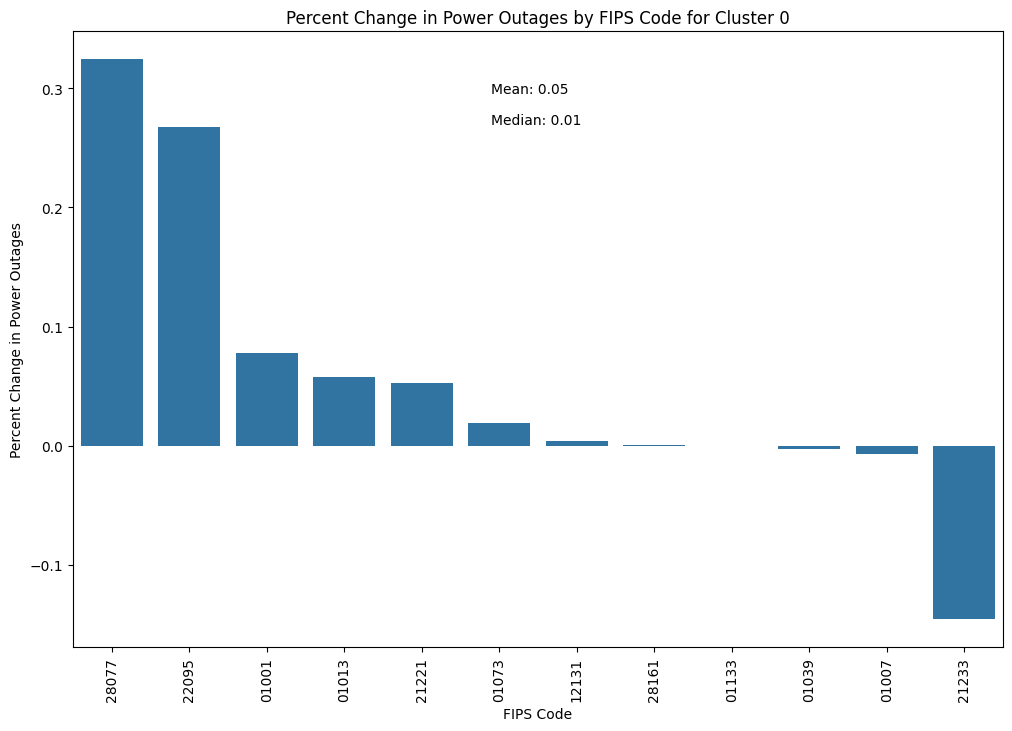

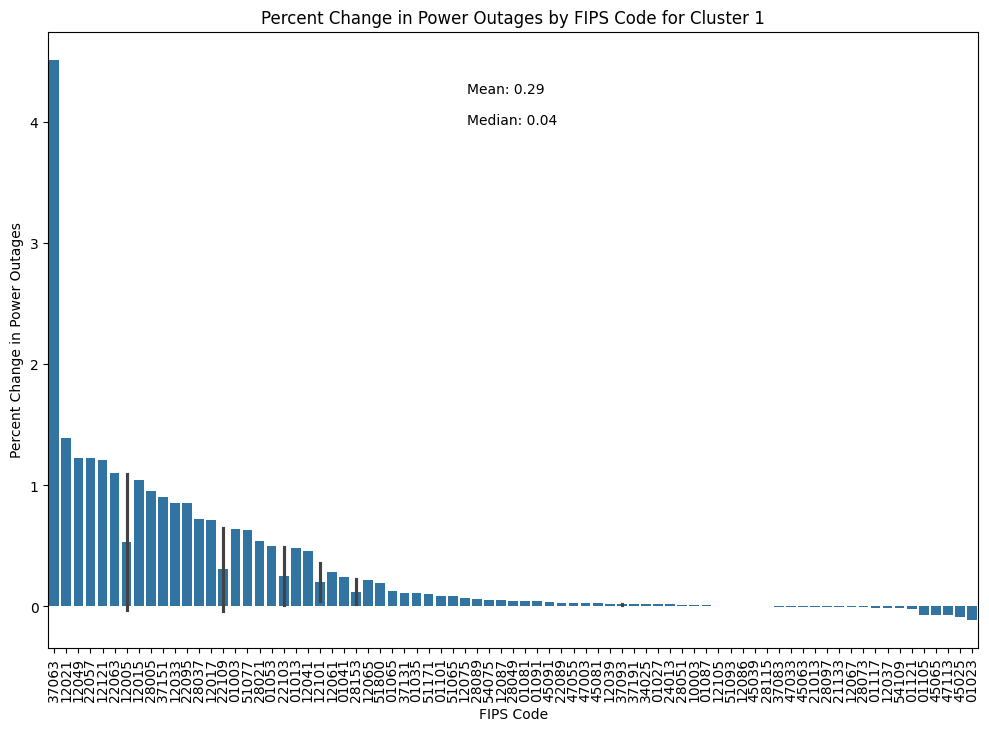

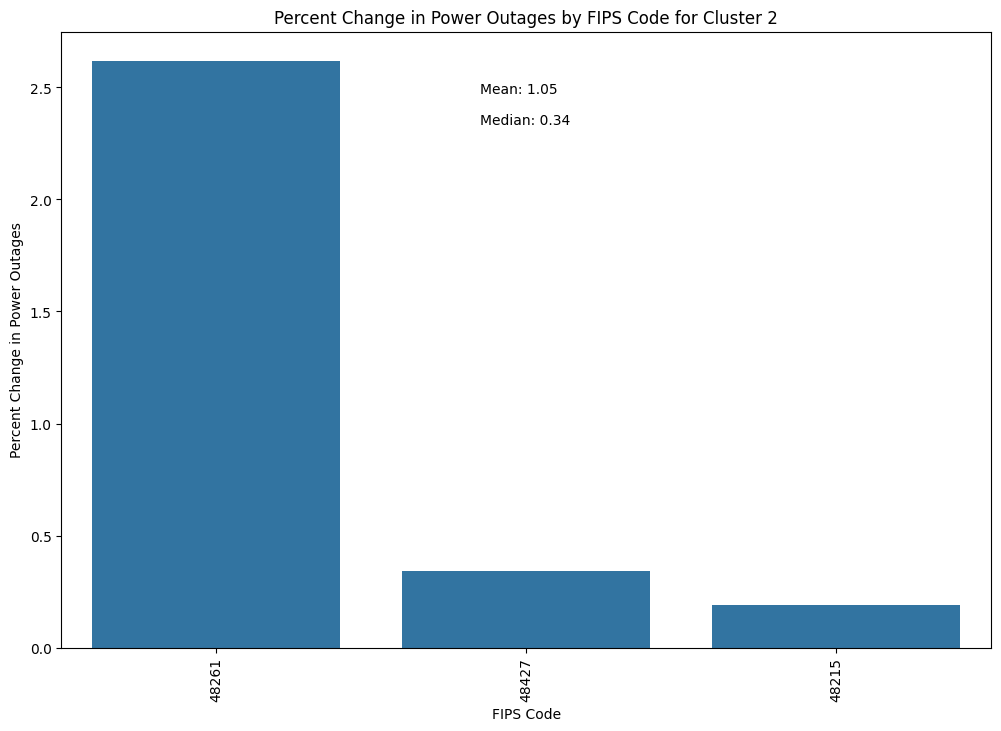

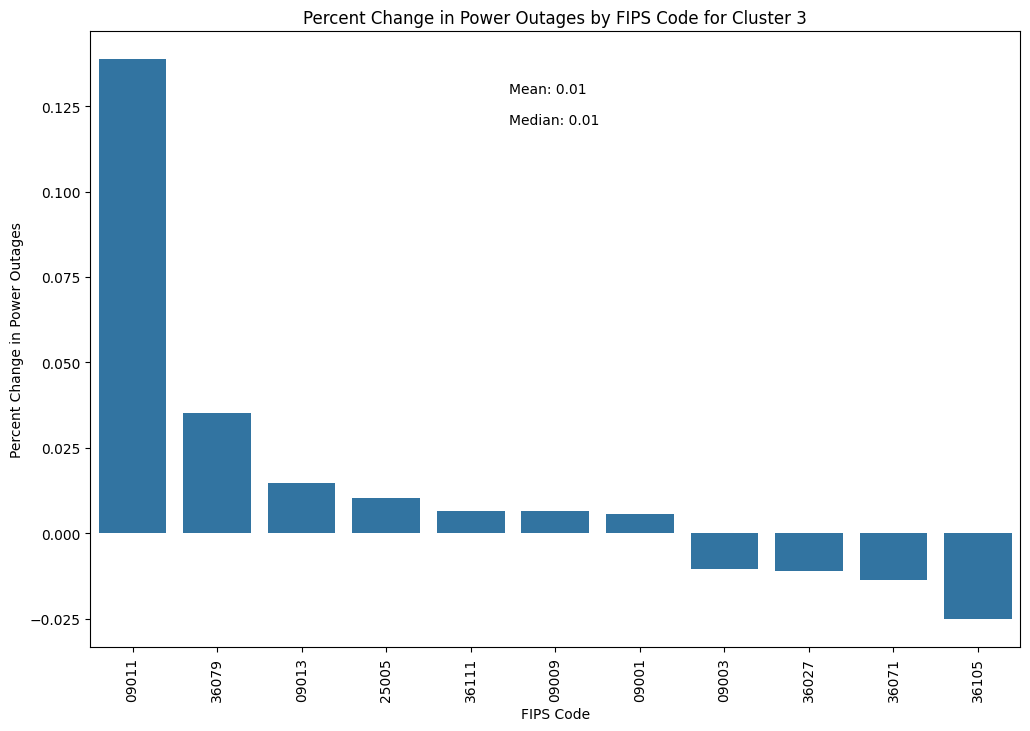

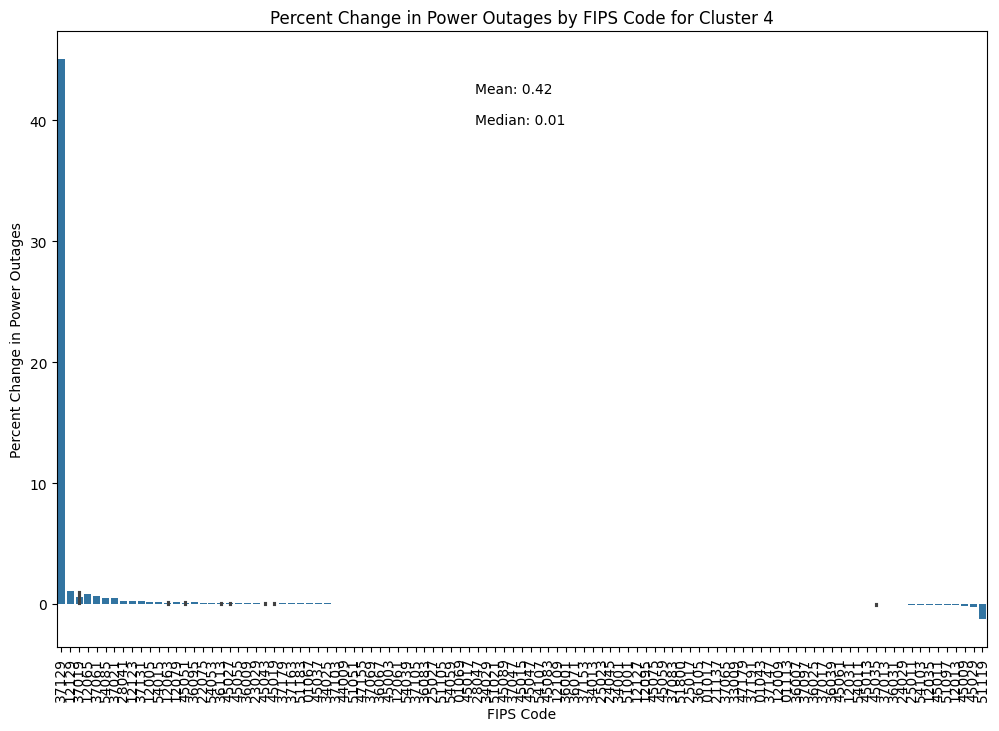

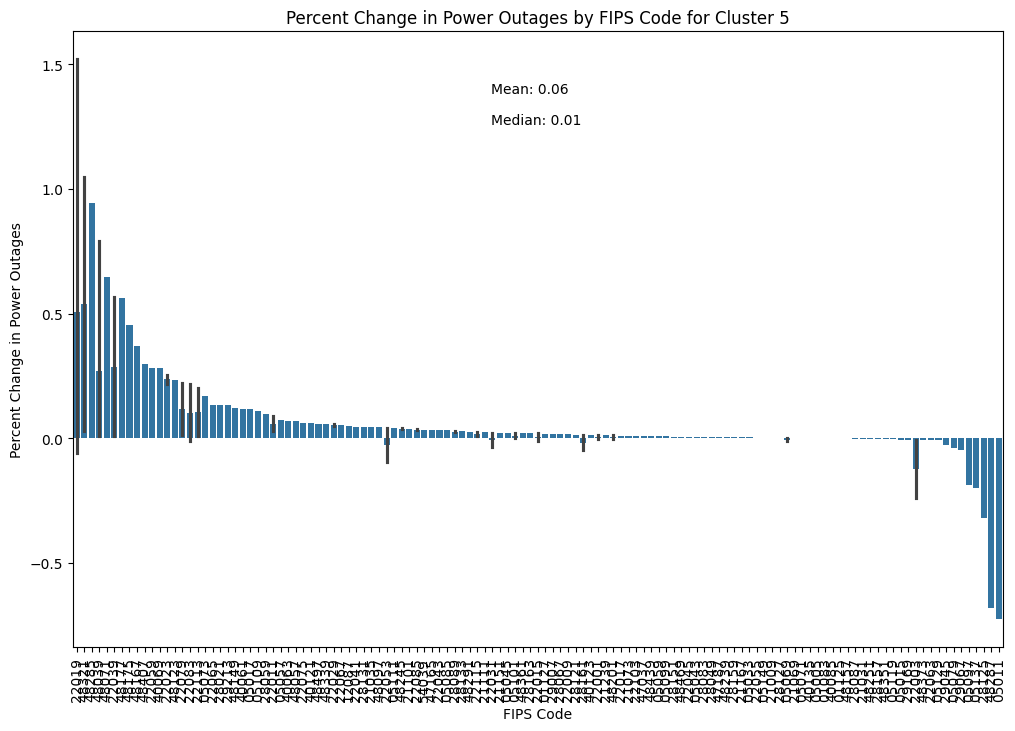

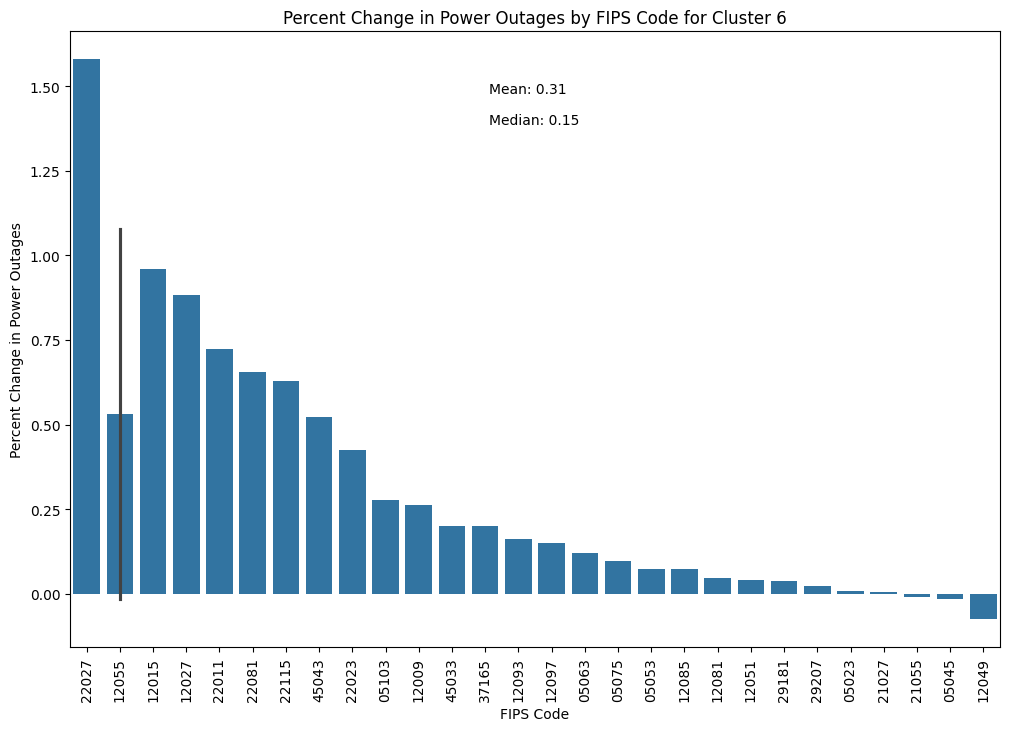

In [233]:
# Plot the fips percent change for each fips code in the cluster
import matplotlib.pyplot as plt
import seaborn as sns

def plot_blackouts_for_cluster(cluster_id):
    fig, ax = plt.subplots(figsize=(12, 8))
    blackouts = get_blackouts_by_fip_for_cluster(
        blackout_by_storm_sid,
        [storm['sid'] for storm in storms_by_cluster_id[cluster_id]]
    )
    blackouts.sort_values(by='percent_change', ascending=False, inplace=True)
    sns.barplot(data=blackouts, x='fips_code', y='percent_change', ax=ax)
    ax.set_title(f'Percent Change in Power Outages by FIPS Code for Cluster {cluster_id}')
    ax.set_ylabel('Percent Change in Power Outages')
    ax.set_xlabel('FIPS Code')

    # Show the mean and median percent change on the plot as text box
    mean = blackouts['percent_change'].mean()
    median = blackouts['percent_change'].median()

    ax.text(0.45, 0.90, f'Mean: {mean:.2f}', transform=ax.transAxes)
    ax.text(0.45, 0.85, f'Median: {median:.2f}', transform=ax.transAxes)
    plt.xticks(rotation=90)
    plt.show()

for cluster_id, cluster in clusters:
    plot_blackouts_for_cluster(cluster_id)
